<a href="https://colab.research.google.com/github/dimaszuda/Battery-LFP-Time-Series/blob/main/Battery_LFP_TimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error

In [ ]:
data = pd.read_csv('SNL_18650_LFP_25C_0-100_0.5-0.5C_a_cycle_data (1).csv')
data.head()

,Cycle_Index,Start_Time,End_Time,Test_Time (s),Min_Current (A),Max_Current (A),Min_Voltage (V),Max_Voltage (V),Charge_Capacity (Ah),Discharge_Capacity (Ah),Charge_Energy (Wh),Discharge_Energy (Wh)
0,1.0,2017-08-07 08:53:16.006963,2017-08-07 13:18:56.019464,15950.019,-0.55,0.549,1.999,3.6,1.046,1.067,3.523,3.439
1,2.0,2017-08-07 13:18:56.128497,2017-08-07 17:43:13.674372,31807.674,-0.55,0.549,1.999,3.6,1.069,1.069,3.582,3.446
2,3.0,2017-08-07 17:43:13.722274,2017-08-07 22:06:54.627952,47628.627,-0.55,0.549,1.998,3.6,1.069,1.070,3.580,3.448
3,4.0,2017-08-07 22:06:54.642112,2017-08-08 06:43:41.658825,78635.658,-0.55,0.549,1.995,3.6,2.137,2.141,7.158,6.899
4,5.0,2017-08-08 06:45:41.697825,2017-08-08 10:56:29.757984,93803.757,-0.55,0.549,1.999,3.6,1.069,1.070,3.576,3.449


In [ ]:
data.drop(data.columns[[1, 2, 10, 11]], axis=1, inplace=True)

In [ ]:
data.tail()

,Cycle_Index,Test_Time (s),Min_Current (A),Max_Current (A),Min_Voltage (V),Max_Voltage (V),Charge_Capacity (Ah),Discharge_Capacity (Ah)
3046,3046.0,4.307966e+07,-0.553,0.546,1.998,3.600,0.957,0.964
3047,3047.0,4.309375e+07,-0.553,0.547,1.998,3.600,0.958,0.963
3048,3048.0,4.310786e+07,-0.553,0.547,1.998,3.600,0.958,0.964
3049,3049.0,4.312196e+07,-0.553,0.547,1.999,3.600,0.958,0.964
3050,3050.0,4.312202e+07,0.000,0.000,2.626,2.633,0.000,0.000


In [ ]:
data.isnull().sum()

Cycle_Index                0
Test_Time (s)              0
Min_Current (A)            0
Max_Current (A)            0
Min_Voltage (V)            0
Max_Voltage (V)            0
Charge_Capacity (Ah)       0
Discharge_Capacity (Ah)    0
dtype: int64

In [ ]:
print(data['Cycle_Index'].max())

3050.0


In [ ]:
cycle = data['Cycle_Index'].values
time = data['Test_Time (s)'].values
capacity = data['Charge_Capacity (Ah)'].values
dc_capacity = data['Discharge_Capacity (Ah)'].values

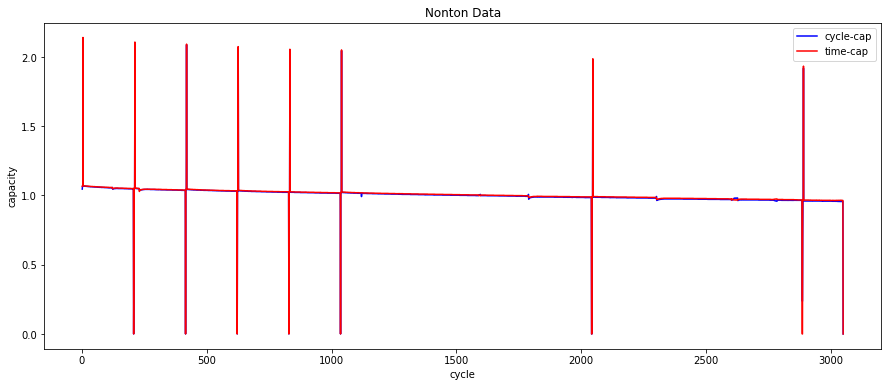

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(cycle, capacity, 'b')
plt.plot(cycle, dc_capacity, 'r')
#plt.plot(time, capacity, 'r')
#plt.plot(cycle, time, 'g--')
plt.title('Nonton Data')
plt.xlabel('cycle')
plt.ylabel('capacity')
plt.legend(['cycle-cap', 'time-cap', 'cycle-time'])
plt.show()

Berdasarkan plot data yang telah dilakukan, didapat kesimpulan bahwa data yang  diperoleh atau digunakan merupakan data time series, sehingga data tidak dapat diolah menggunakan regresi.

In [ ]:
SoC = data[['Charge_Capacity (Ah)']].values
label = data[['Cycle_Index']]

jumlah SoC disesuaikan dengan jumlah label_train atau label_test dengan menerapkan loc atau iloc

In [ ]:
SoC.shape

(3051, 1)

In [ ]:
label.shape

(3051, 1)

In [ ]:
SoC_latih, SoC_test, label_latih, label_test = train_test_split(SoC, label, test_size=0.2, shuffle=False)
len(SoC_test)

611

In [ ]:
train_stats = label_latih.describe().transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cycle_Index,2440.0,1221.052049,704.245638,1.0,611.75,1221.5,1830.25,2440.0


In [ ]:
def dataset_window(series, window_size, batch_size, shuffle_buffer):
  #series = tf.expand_dims(series, axis=1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size+1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size+1))
  if shuffle_buffer:
    ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  ds = ds.map(lambda x, y: (tf.expand_dims(x, axis=-1), y))
  return ds.batch(batch_size).prefetch(1)

In [ ]:
input = tf.keras.layers.Input(shape=(60, 1))
input

<KerasTensor: shape=(None, 60, 1) dtype=float32 (created by layer 'input_1')>

In [ ]:
train_setting = dataset_window(SoC_latih, window_size=60, batch_size=90, shuffle_buffer=500)

In [ ]:
model = tf.keras.models.Sequential([
                                    input,
                                    tf.keras.layers.LSTM(60, return_sequences=False),
                                    tf.keras.layers.Dense(30, activation='relu'),
                                    tf.keras.layers.Dense(10, activation='relu'),
                                    tf.keras.layers.Dense(1)
])

In [ ]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-4, momentum=0.9)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=['mae'])

In [ ]:
model.build(input_shape=(10,))
model

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60)                14880     
                                                                 
 dense (Dense)               (None, 30)                1830      
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 17,031
Trainable params: 17,031
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(train_setting, epochs=60)

Epoch 1/60
27/27 [==============================] - 4s 63ms/step - loss: 0.5061 - mae: 1.0033
Epoch 2/60
27/27 [==============================] - 2s 53ms/step - loss: 0.2998 - mae: 0.7681
Epoch 3/60
27/27 [==============================] - 2s 55ms/step - loss: 0.1656 - mae: 0.5710
Epoch 4/60
27/27 [==============================] - 2s 55ms/step - loss: 0.1002 - mae: 0.4425
Epoch 5/60
27/27 [==============================] - 1s 49ms/step - loss: 0.0602 - mae: 0.3404
Epoch 6/60
27/27 [==============================] - 1s 49ms/step - loss: 0.0358 - mae: 0.2588
Epoch 7/60
27/27 [==============================] - 1s 49ms/step - loss: 0.0215 - mae: 0.1956
Epoch 8/60
27/27 [==============================] - 2s 55ms/step - loss: 0.0133 - mae: 0.1469
Epoch 9/60
27/27 [==============================] - 2s 55ms/step - loss: 0.0087 - mae: 0.1099
Epoch 10/60
27/27 [==============================] - 1s 50ms/step - loss: 0.0061 - mae: 0.0819
Epoch 11/60
27/27 [==============================] - 1s 50m

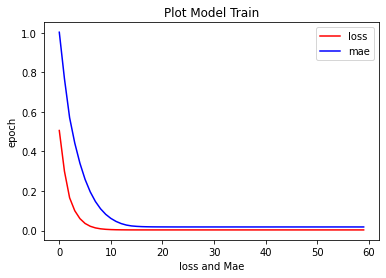

In [ ]:
plt.plot(history.history['loss'], 'r')
plt.plot(history.history['mae'], 'b')
plt.title('Plot Model Train')
plt.xlabel('loss and Mae')
plt.ylabel('epoch')
plt.legend(['loss', 'mae'], loc='upper right')
plt.show()

In [ ]:
print("Nilai mae yang diperoleh adalah", min(history.history['mae']), end=', ')
print("\nNilai loss yang diperoleh adalah", min(history.history['loss']), end=', ')

Nilai mae yang diperoleh adalah 0.01801268383860588, 
Nilai loss yang diperoleh adalah 0.0030812935438007116, 

alasan kenapa jumlah train setting nya berubah adalah karena pengaruh dari window size di kode diatas

In [ ]:
prediksi = model.predict(SoC_latih[60][np.newaxis])
prediksi

array([[0.4535595]], dtype=float32)

In [ ]:
timeseries = []
for time in range(len(SoC) - 60):
  timeseries.append(model.predict(SoC[time:time + 60][np.newaxis]))
timeseries = timeseries[2440 - 60:]
hasil = np.array(timeseries)[:, 0, 0]

In [ ]:
print(len(hasil))

611


In [ ]:
mae = mean_absolute_error(SoC_test, hasil)
mae

0.032410564850278094

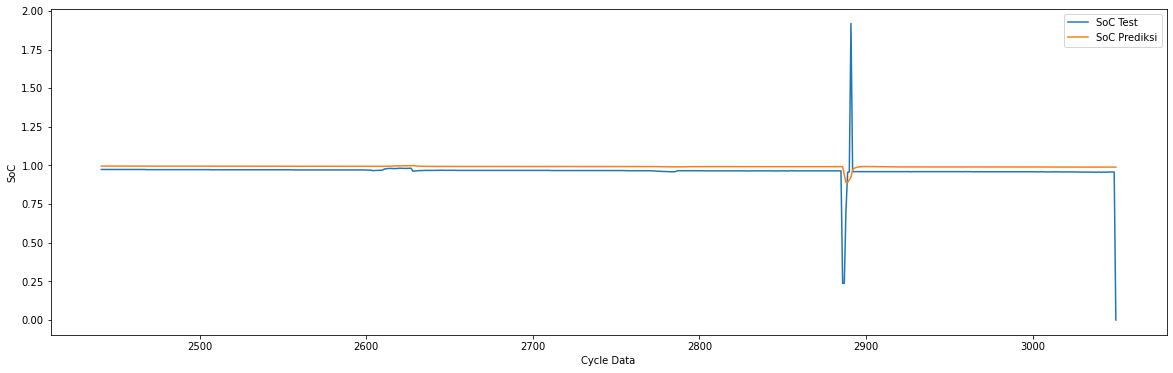

In [ ]:
plt.figure(figsize=(20,6))
plt.plot(label_test, SoC_test)
plt.plot(label_test, hasil)
plt.xlabel("Cycle Data")
plt.ylabel("SoC")
plt.legend(["SoC Test", "SoC Prediksi"])
plt.show()